In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [ ]:
AST_PATH = "../data/asteroids_sample.csv"
COM_PATH = "../data/comets_clean.csv"

# Load and label
ast = pd.read_csv(AST_PATH).assign(label=1)  # asteroid
com = pd.read_csv(COM_PATH).assign(label=0)  # comet

# Use shared features only
features = ["e", "q", "i"]
ast = ast[features + ["label"]].dropna()
com = com[features + ["label"]].dropna()


# ast = ast.sample(n=len(com), random_sttae=42)

df = pd.concat([ast, com], ignore_index=True)
X = df[features]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Baseline: logistic with scaling
logreg = make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000))
logreg.fit(X_train, y_train)
print("\nBASELINE LOGISTIC REGRESSION")
print(classification_report(y_test, logreg.predict(X_test), target_names=["comet", "asteroid"]))

# Tree model: random forest (no scaling needed)
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)
print("\nRANDOM FOREST MODEL")
print(classification_report(y_test, rf.predict(X_test), target_names=["comet", "asteroid"]))


BASELINE LOGISTIC REGRESSION
              precision    recall  f1-score   support

       comet       1.00      0.99      1.00       200
    asteroid       1.00      1.00      1.00       200

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400


RANDOM FOREST MODEL
              precision    recall  f1-score   support

       comet       1.00      0.99      1.00       200
    asteroid       1.00      1.00      1.00       200

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



## Plots/Visualization

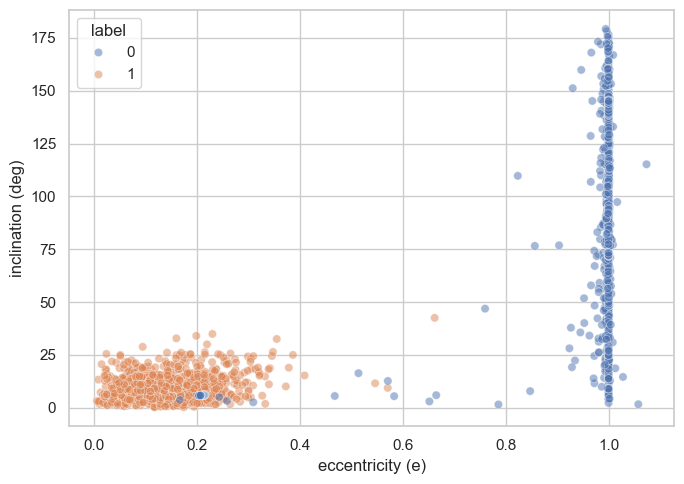

In [ ]:
sns.set_theme(style="whitegrid")
plot_dir = Path("../plots_Asteroids_Comets"); plot_dir.mkdir(exist_ok=True)

# Scatter: eccentricity vs inclination
plt.figure(figsize=(7,5))
sns.scatterplot(data=df, x="e", y="i", hue="label", alpha=0.5)
plt.xlabel("eccentricity (e)")
plt.ylabel("inclination (deg)")
plt.tight_layout()
plt.savefig(plot_dir / "comets_vs_asteroids_e_i.png", dpi=200, bbox_inches="tight")
plt.show()
plt.close()

# KDE of perihelion distance
g = sns.displot(data=df, x="q", hue="label", kind="kde", fill=True)
g.set_axis_labels("perihelion distance (q)", "Density")
g.fig.savefig(plot_dir / "comets_vs_asteroids_q_kde.png", dpi=200, bbox_inches="tight")
plt.show()
plt.close(g.fig)

## Added a cross-val.

In [4]:
from sklearn.model_selection import cross_val_score
rf = RandomForestClassifier(n_estimators=300, random_state=42)
scores = cross_val_score(rf, X, y, cv=5, scoring="accuracy")
print("CV accuracy mean:", scores.mean(), "std:", scores.std())


CV accuracy mean: 0.9845 std: 0.01983683442487741


## ablation, dropped one feature

In [5]:
for drop in [["e"], ["q"], ["i"]]:
    feats = [f for f in features if f not in drop]
    X_sub = df[feats]; y_sub = df["label"]
    X_train, X_test, y_train, y_test = train_test_split(
        X_sub, y_sub, stratify=y_sub, test_size=0.2, random_state=42
    )
    rf = RandomForestClassifier(n_estimators=300, random_state=42)
    rf.fit(X_train, y_train)
    print(f"Dropping {drop}: accuracy {rf.score(X_test, y_test):.3f}")


Dropping ['e']: accuracy 0.988
Dropping ['q']: accuracy 0.993
Dropping ['i']: accuracy 0.998
